In [1]:
import numpy as np
import networkx as nx
import pandas as pd
from numpy.random import uniform, randint
from node import EpidemicGraph, TransitionDiagram, calc_R0
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from random import sample
import random
import math
%matplotlib inline

In [2]:
def plot(G, title='step_1', ns=1000, fs=12, lim=2, lim_begin=0, figsize=(5, 5)):
    pos = nx.get_node_attributes(G, 'position')
    ids = {i:i for i in range(N)}
    print('Total node number', N)
    
    s_a = [x for x,y in G.nodes(data=True) if y['state']=='S_a']
    s_s = [x for x,y in G.nodes(data=True) if y['state']=='S_s']
    i1_a = [x for x,y in G.nodes(data=True) if y['state']=='I1_a']
    i1_s = [x for x,y in G.nodes(data=True) if y['state']=='I1_s']
    i2_a = [x for x,y in G.nodes(data=True) if y['state']=='I2_a']
    i2_s = [x for x,y in G.nodes(data=True) if y['state']=='I2_s']

    color = ['#ff6666','#cc0000','#3399ff','#0000cc']
    fig = plt.figure(figsize=figsize)
    nx.draw_networkx_edges(G, pos, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_a, node_color='#66ff99')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=s_s, node_color='#006600')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_a, node_color='#ff6666')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i1_s, node_color='#cc0000')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_a, node_color='#3399ff')
    nx.draw_networkx_nodes(G, pos, node_size=ns, nodelist=i2_s, node_color='#0000cc')
    nx.draw_networkx_labels(G, pos, ids, font_size=fs)

    plt.title(title)
    red_patch = mpatches.Patch(color='red', label='I1')
    blue_patch = mpatches.Patch(color='blue', label='I2')
    green_patch = mpatches.Patch(color='green', label='S')
    plt.legend(handles=[green_patch, red_patch, blue_patch])
    plt.xlim(lim_begin, lim)
    plt.ylim(lim_begin, lim)
    return plt, fig

((0.7911889907462122+0j), 22.307098293815095) (1, 0)
Total node number 100


C:\Users\DFed\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


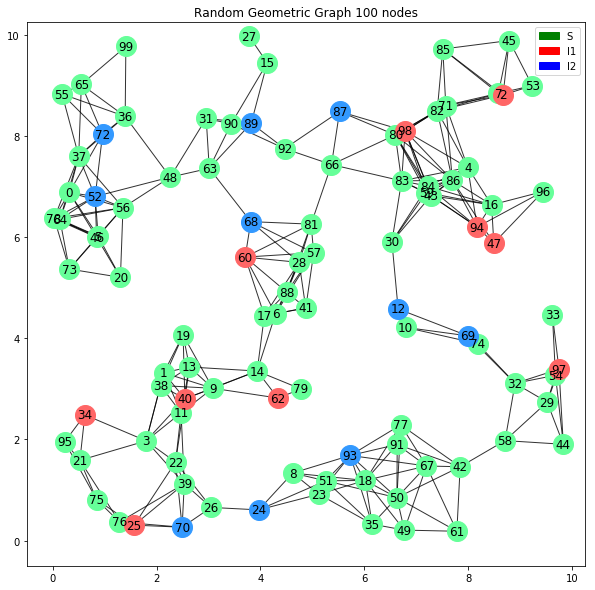

In [3]:
# generate network
paramet = {
        'alpha': [0.05, 0.35], # infect rate 
        'mu': [0.02, 0.02], # sleep s 
        'gamma': [0.2, 0.02], # rec rate 
        'lambda': [0.02, 0.1], # sleep I1 
        'kappa': [0.04, 0.05] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }

np.random.seed(310)  # structure
random.seed(6)       # infected
N = 100
r = 1.5
number_subgraphs = 0
while number_subgraphs != 1:
    a = EpidemicGraph(N,r,paramet,I1_a=10//2, I2_a=10//2, grid_size=[math.sqrt(N), math.sqrt(N)]) #, net='Uniform Grid'
    a.load_csv('100 nodes.csv',10,10)
    number_subgraphs = len(list(nx.connected_component_subgraphs(a.G)))
    number_isolated_nodes = len(list(nx.isolates(a.G)))
    print(calc_R0(a.G, paramet), (number_subgraphs, number_isolated_nodes))

# a.save_csv('{} nodes.csv'.format(N))
plt, fig = plot(a.G,lim=math.sqrt(N+5),lim_begin=-0.5, figsize=(10, 10), ns=400, title='Random Geometric Graph 100 nodes')
fig.savefig('fig/_.png', bbox_inches='tight')

In [4]:
def monte(n, N, r, paramet, nstep=300, I1_a=10, I2_a=10, csv=None):
    listt = []
    # print(csv)
    for i in range(n):
        a = EpidemicGraph(N, r, paramet, I1_a=I1_a, I2_a=I2_a, grid_size=[30,30])
        if csv is not None:
            a.load_csv(csv, I0=I1_a, I1=I2_a)
        else:
            print(calc_R0(a.G, paramet))
        a.run(nstep)
        listt.append(a.hist2pandas())
        print(i+1, end='\r')
    print(calc_R0(a.G, paramet))
    print()
    df = listt[0]
    del listt[0]
    for v in listt:
        df += v
    df /= n
    return df, a


(22.307098293815095, (0.7911889907462122+0j))

Total node number 100


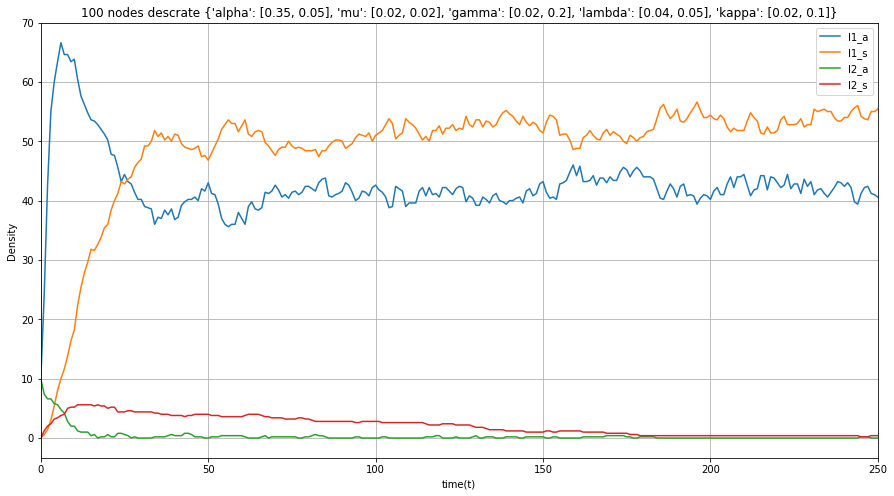

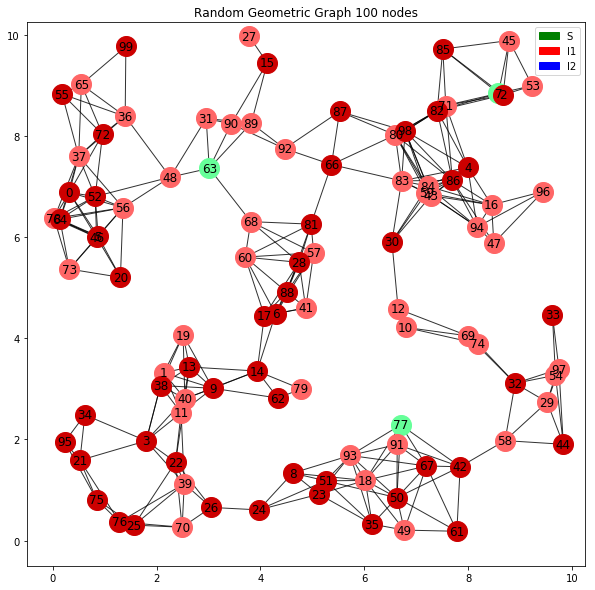

In [5]:
paramet = { # R10
        'alpha': [0.35, 0.05], # infect rate 
        'mu': [0.02, 0.02], # sleep s 
        'gamma': [0.02, 0.2], # rec rate 
        'lambda': [0.04, 0.05], # sleep I1 
        'kappa': [0.02, 0.1] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
    }
# paramet = {  # R11
#         'alpha': [0.1, 0.35], # infect rate 
#         'mu': [0.02, 0.02], # sleep s 
#         'gamma': [0.05, 0.02], # rec rate 
#         'lambda': [0.03, 0.04], # sleep I1 
#         'kappa': [0.04, 0.05] # sleep I2    % [I2_s -> I2_a, I2_a -> I2_s]
#     }
N = 100
r = 1.5
asd_monte, a = monte(5, N, r, paramet, 400, csv='100 nodes.csv')

asd1 = asd_monte[['I1_a','I1_s','I2_a','I2_s']] # /N
f = asd1.plot(grid=True,figsize=[15,8])
plt.title('100 nodes descrate {}'.format(paramet))
plt.xlabel('time(t)')
plt.ylabel('Density')
plt.xlim([0, 250])
# plt.ylim([-0.05, 0.6])
# f.get_figure().savefig('fig/discreate.png', bbox_inches='tight')
calc_R0(a.G, paramet)

# asd_monte.to_csv('rnd_dis.csv', header=None, index=None)
plt, fig = plot(a.G,lim=math.sqrt(N+5),lim_begin=-0.5, figsize=(10, 10), ns=400, title='Random Geometric Graph 100 nodes')
fig.savefig('fig/_end.png', bbox_inches='tight')

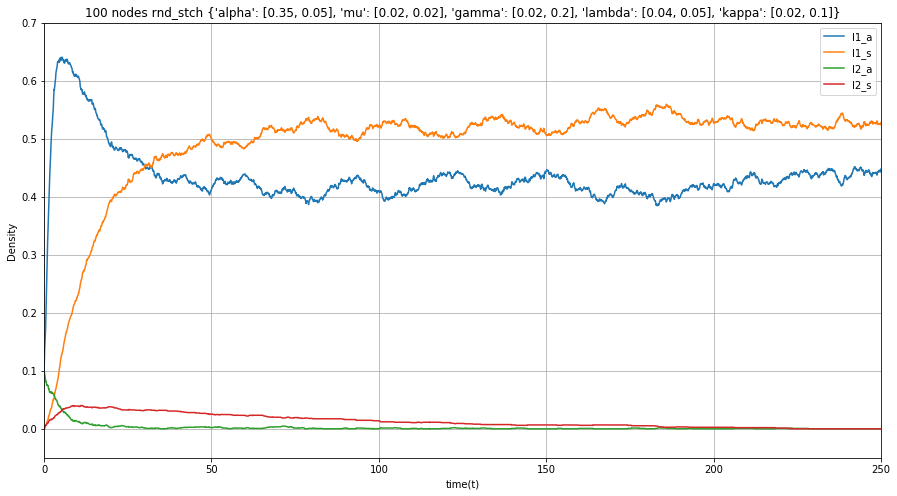

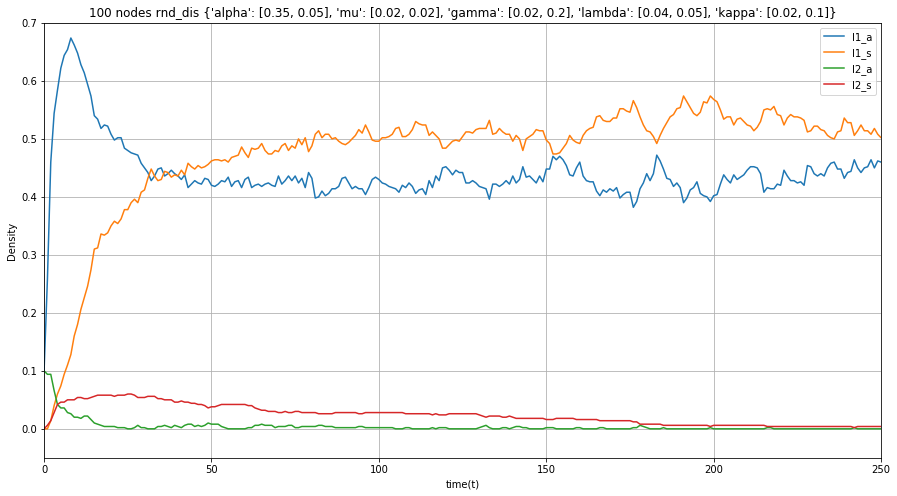

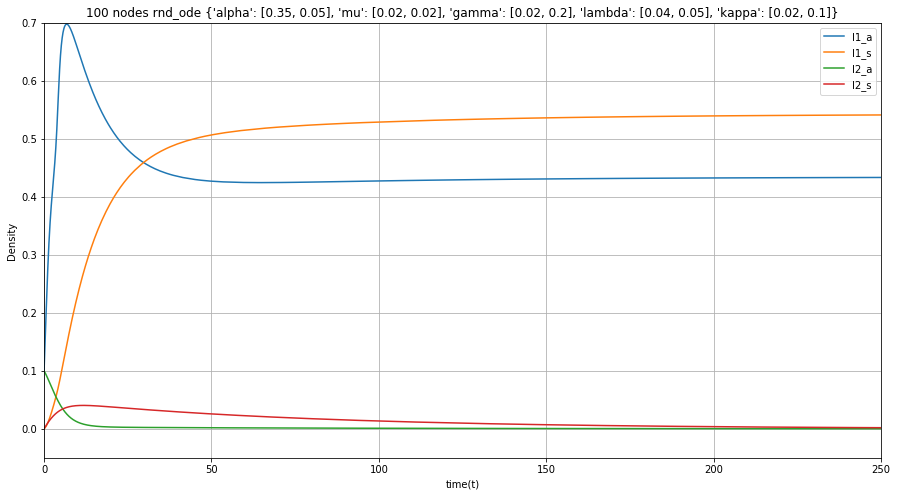

In [6]:
# read matlab rnd_stch
csv_list = ['rnd_stch.csv', 'rnd_dis.csv', 'rnd_ode.csv']
linestyles = ['-', '--', '-.', ':']
dt_list = [20,1,20]
for csv,dt in zip(csv_list, dt_list):
    column_list = ['S_a','S_s','I1_a', 'I1_s','I2_a','I2_s']
    pdf_title = 'fig/{}.png'.format(csv.split('.')[0])
    asd = pd.read_csv(csv,names = column_list)
    asd1 = asd[['I1_a', 'I1_s','I2_a','I2_s']] / N
    asd1['t'] = np.array(range(0, asd.shape[0])) / dt
    f = asd1[['t','I1_a', 'I1_s','I2_a','I2_s']].plot(x='t', grid=True, figsize=[15,8])
    plt.title('{} nodes {} {}'.format(N, csv.split('.')[0], paramet)) 
    plt.xlabel('time(t)')
    plt.ylabel('Density')
    plt.xlim([0, 250])
    plt.ylim([-0.05,0.7])
    f.get_figure().savefig(pdf_title, bbox_inches='tight')

## Figures for presentation

fig/r11/rnd_stch.csv
fig/r11/rnd_dis.csv
fig/r11/rnd_ode.csv
fig/r01/rnd_stch.csv
fig/r01/rnd_dis.csv
fig/r01/rnd_ode.csv
fig/r00/rnd_stch.csv
fig/r00/rnd_dis.csv
fig/r00/rnd_ode.csv


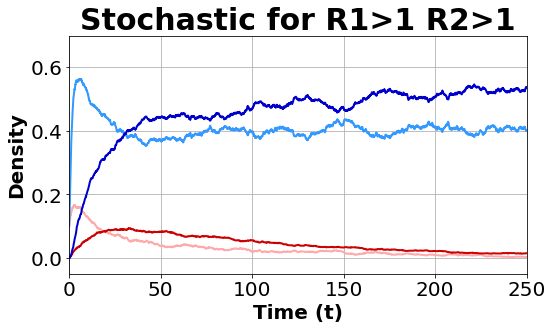

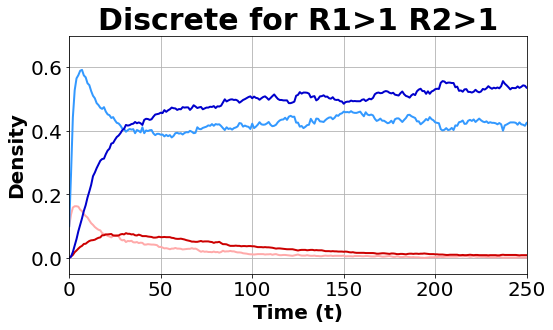

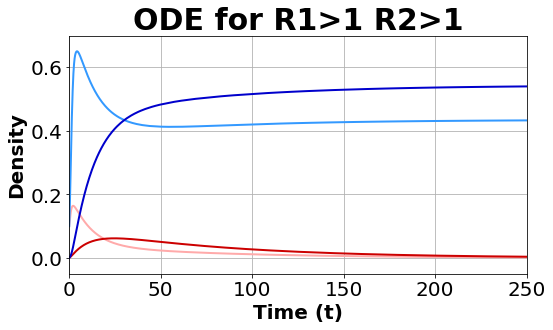

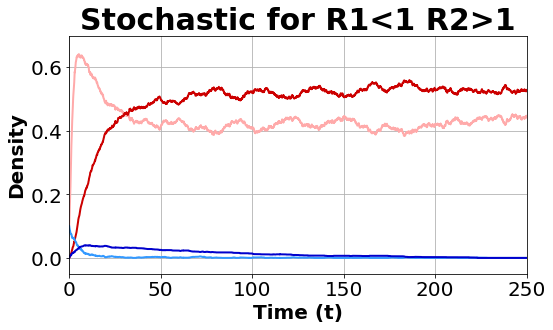

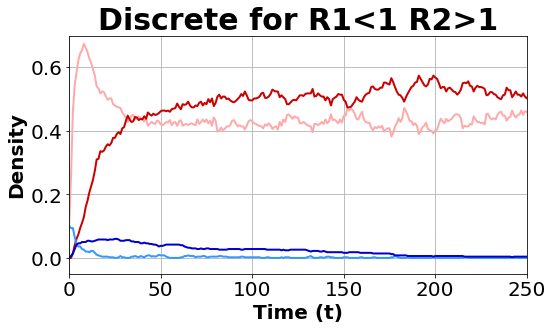

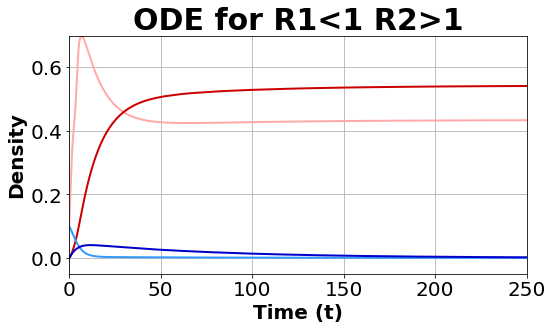

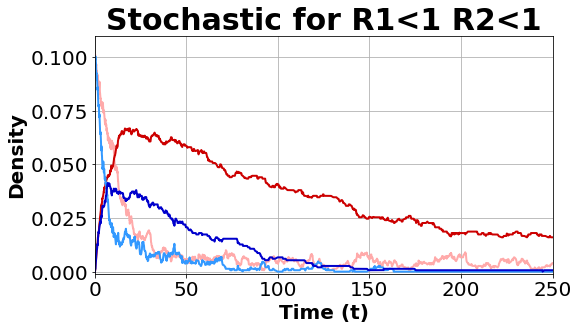

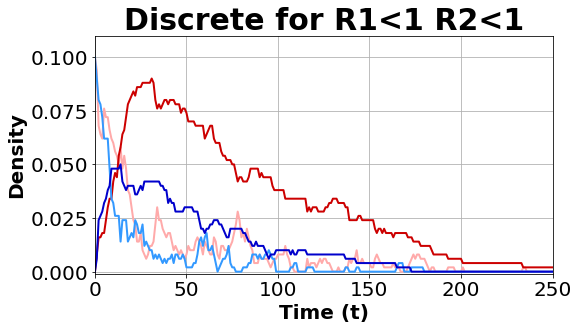

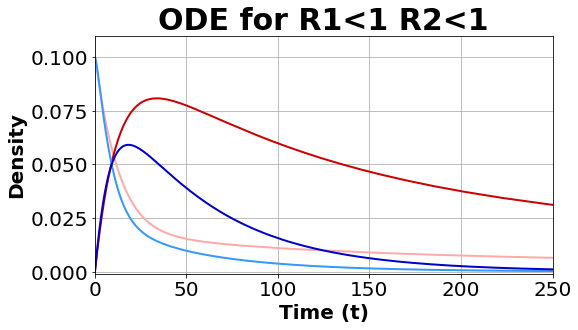

In [10]:
# read matlab rnd_stch
N = 100
folder_list = ['fig/r11','fig/r01','fig/r00']
folder_repr = ['R1>1 R2>1','R1<1 R2>1','R1<1 R2<1']
output_repr = ['R11','R01','R00']
folder_ylim = [[-0.05,0.7],[-0.05,0.7],[-0.001,0.11]]
csv_list = ['rnd_stch.csv', 'rnd_dis.csv', 'rnd_ode.csv']
sim_type_list = ['Stochastic', 'Discrete', 'ODE']
linestyles = ['-', '--', '-.', ':']
dt_list = [20,1,20]
plt.rcParams.update({'font.size': 20})
for folder, repr_ratio, ylim, orepr in zip(folder_list, folder_repr, folder_ylim, output_repr):
    for csv,dt,sim_type in zip(csv_list, dt_list, sim_type_list):
        column_list = ['S_a','S_s','I1_a', 'I1_s','I2_a','I2_s']
        pic_title = f'fig_p/{orepr}_{csv.split(".")[0]}.png'
        print(f'{folder}/{csv}')
        asd = pd.read_csv(f'{folder}/{csv}', names = column_list)
        asd1 = asd[['I1_a', 'I1_s','I2_a','I2_s']] / N
        asd1['t'] = np.array(range(0, asd.shape[0])) / dt
        # plo
        f = asd1[['t','I1_a', 'I1_s','I2_a','I2_s']].plot(x='t', grid=True, figsize=[12.3/1.5, 6.573/1.5],
                                                          linewidth=2,
                                                          color=['#ffaaaa','#cc0000','#3399ff','#0000cc'])
        plt.title(f'{sim_type} for {repr_ratio}', fontsize=30,fontweight="bold") 
        ax = plt.gca()
        plt.legend(loc=7)
        ax.get_legend().remove()
        plt.xlabel('Time (t)', fontweight="bold")
        plt.ylabel('Density', fontweight="bold")
        plt.xlim([0, 250])
        plt.ylim(ylim)
        f.get_figure().savefig(pic_title, bbox_inches='tight')